<img src="img/ibidat.png" alt="drawing" width="600"/>

# Introducción

En este cuaderno vamos a aplicar un único algoritmo con dos atributos sensibles en el dataset `homecredit`.


# Carga de librerías


In [1]:
# Con esta celda, podemos hacer cambios en cualquier script/libreria y verlo reflejado en las funciones del notebook.
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## CARGAMOS LIBRERIAS
# Obs: La primera vez puede tardar en cargar porque AIF360 pre-compila algunas cosas de tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargamos librerías de sklearn
# vanilla LR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Cargamos xgboost
from xgboost import XGBClassifier

# Cargamos algoritmos de fairness
# Pre-procesado
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing import DisparateImpactRemover
# In-procesado
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing
# Post-procesado
from aif360.algorithms.postprocessing import RejectOptionClassification # when scores are given
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing # when scores (R) are given
from aif360.algorithms.postprocessing import EqOddsPostprocessing # when labels (Y^hat) are given
from aif360.datasets import GermanDataset

# TF para adversarial debiasing
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

from IPython.display import Markdown, display

# Librería local con funciones de ayuda extra
import utils

seed = 12345 # fijamos la semilla de números aleatorios para reproducir exactamante el notebook

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

# Selección de dataset.

El siguiente bloque permite seleccionar el conjunto de datos sobre el que trabajar. Debe recordarse que el conjunto de `homecredit` es mucho mayor por lo que tardará más tiempo en ejecutarse.


In [3]:
dataset_name = 'homecredit' # valid options are: german; homecredit

if dataset_name == 'german':
    dataset_german = GermanDataset(
        protected_attribute_names=['age'],            
        privileged_classes=[lambda x: x >= 25],      
        features_to_drop=['personal_status', 'sex'] 
    )
    

    # xgboost requiere que los labels empiecen en 0, y en este conjunto empiezan en 1
    # dataset_german.labels = dataset_german.labels - 1
    # dataset_german.favorable_label = dataset_german.favorable_label - 1
    # dataset_german.unfavorable_label = dataset_german.unfavorable_label - 1
    # cambiar los labels 2 a 0 (label 2 es desfavorabel y 1 es favorable) 
    dataset_german.labels[dataset_german.labels.ravel() == 2] =  dataset_german.labels[dataset_german.labels.ravel() == 2] - 2
    dataset_german.unfavorable_label = dataset_german.unfavorable_label - 2

    
    
    # Separamos el conjunto de datos en train, validate, test
    data_train, vt = dataset_german.split([0.7], shuffle=True, seed=seed)
    data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

    # Obtenemos los indicadores del grupo sensible
    sensitive_attribute = dataset_german.protected_attribute_names[0] # age
    privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_german)
    
    print(f'Dimensiones del conjunto de datos: {dataset_german.features.shape}')
    print("Grupos privilegiados:", privileged_groups)
    print("Grupos no privilegiados:", unprivileged_groups)
    print("Label del grupo favorable:", dataset_german.favorable_label)
    print("Label del grupo desfavorable:", dataset_german.unfavorable_label) 
    
elif dataset_name == 'homecredit':
    dataset_homecredit = pd.read_csv('data/homecredit.csv', header=0, sep=',', quotechar='"')

    dataset_homecredit = utils.preprocess_homecredit_mult(dataset_homecredit)
    dataset_homecredit_2 = dataset_homecredit.copy(deep = True)
    
    dataset_homecredit_aif = utils.convert_to_standard_dataset(
            df=dataset_homecredit,
            target_label_name='TARGET',
            sensitive_attribute=['PROT_ATTR'],
            priviledged_classes=[lambda x: x == 1],
            favorable_target_label=[0],
            features_to_keep=[],
            categorical_features=[])

    dataset_homecredit_aif_2 = utils.convert_to_standard_dataset(
            df=dataset_homecredit_2,
            target_label_name='TARGET',
            sensitive_attribute=['AGE'],
            priviledged_classes=[lambda x: x >= 25],
            favorable_target_label=[0],
            features_to_keep=[],
            categorical_features=[])

    # para hacer submuestra 
    sample_size_hc = 5000
    ssample = np.random.randint(0, 307511+1, size=(sample_size_hc))
    dataset_homecredit_aif = dataset_homecredit_aif.subset(ssample)
    dataset_homecredit_aif_2 = dataset_homecredit_aif_2.subset(ssample)
else:
    print('Invalid dataset selected')

/home/arturo_perez/DEFINITIVO/utils.py:1173: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['AGE'] = -df['DAYS_BIRTH'].astype('float') / 365
/home/arturo_perez/DEFINITIVO/utils.py:1176: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:,'PROT_ATTR'] = 0.0


In [4]:
# cambiar los labels: 1 para good y 0 para bad     
good_customers = dataset_homecredit_aif.labels.ravel() == 0
bad_customers = ~good_customers
dataset_homecredit_aif.labels[good_customers] = np.array([1])
dataset_homecredit_aif.labels[bad_customers] = np.array([0])
    
dataset_homecredit_aif.favorable_label = 1
dataset_homecredit_aif.unfavorable_label = 0

# cambiar los labels: 1 para good y 0 para bad     
good_customers = dataset_homecredit_aif_2.labels.ravel() == 0
bad_customers = ~good_customers
dataset_homecredit_aif_2.labels[good_customers] = np.array([1])
dataset_homecredit_aif_2.labels[bad_customers] = np.array([0])
    
dataset_homecredit_aif_2.favorable_label = 1
dataset_homecredit_aif_2.unfavorable_label = 0
    
# Separamos el conjunto de datos en train, validate, test
data_train, vt = dataset_homecredit_aif.split([0.7], shuffle=True, seed=seed)
data_val, data_test = vt.split([0.5], shuffle=True, seed=seed)

data_train2, vt2 = dataset_homecredit_aif_2.split([0.7], shuffle=True, seed=seed)
data_val2, data_test2 = vt2.split([0.5], shuffle=True, seed=seed)

# Obtenemos los indicadores del grupo sensible
sensitive_attribute = dataset_homecredit_aif.protected_attribute_names[0] # age
privileged_groups, unprivileged_groups = utils.get_privileged_groups(dataset_homecredit_aif)

print(f'Dimensiones del conjunto de datos: {dataset_homecredit_aif.features.shape}')
print("Grupos privilegiados:", privileged_groups)
print("Grupos no privilegiados:", unprivileged_groups)
print("Label del grupo favorable:", dataset_homecredit_aif.favorable_label)
print("Label del grupo desfavorable:", dataset_homecredit_aif.unfavorable_label) 

Dimensiones del conjunto de datos: (5000, 229)
Grupos privilegiados: [{'PROT_ATTR': 1.0}]
Grupos no privilegiados: [{'PROT_ATTR': 0.0}]
Label del grupo favorable: 1
Label del grupo desfavorable: 0


## Modelos
Para esta sección, creamos un diccionario de métricas y modelos para poder acceder los resultados de todos los modelos.

In [5]:
# Inicializamos diccionarios
models = dict()

# Rango de umbrales para evaluar el score de los modelos
thresh_sweep = np.linspace(0.01, 1.0, 50)

metrics_sweep = dict()

# Store results from validation and test
metrics_best_thresh_validate = dict()
metrics_best_thresh_test = dict()

### Regresión Logística

In [6]:
%%time 

# Nombramos al modelo
model_name = 'logistic_regression'
fairness_method = ''

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

CPU times: user 2.81 s, sys: 2.85 s, total: 5.67 s
Wall time: 5.68 s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6035
Balanced accuracy: 0.5863
Accuracy: 0.4587
Independence ( |ΔP(Y_pred = 1)| ): 0.4089
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1921
Sufficiency ( |ΔPPV| ) : 0.9557
CPU times: user 26.6 s, sys: 35.5 s, total: 1min 2s
Wall time: 55.4 s


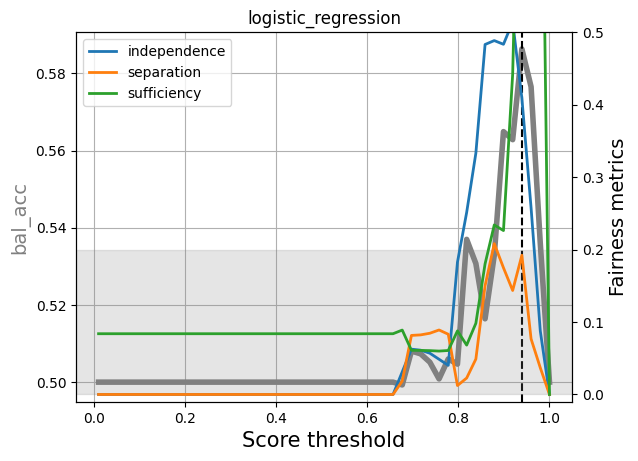

In [7]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy, 
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

In [8]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6302
Balanced accuracy: 0.5756
Accuracy: 0.4440
Independence ( |ΔP(Y_pred = 1)| ): 0.4185
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0763
Sufficiency ( |ΔPPV| ) : 0.9439


### XGBoost

In [9]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'
fairness_method = ''

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

CPU times: user 48min 2s, sys: 3.27 s, total: 48min 6s
Wall time: 2min 21s


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9798
AUC: 0.7285
Balanced accuracy: 0.6730
Accuracy: 0.5147
Independence ( |ΔP(Y_pred = 1)| ): 0.3173
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2086
Sufficiency ( |ΔPPV| ) : 0.1794
CPU times: user 26.7 s, sys: 23.8 s, total: 50.4 s
Wall time: 50.7 s


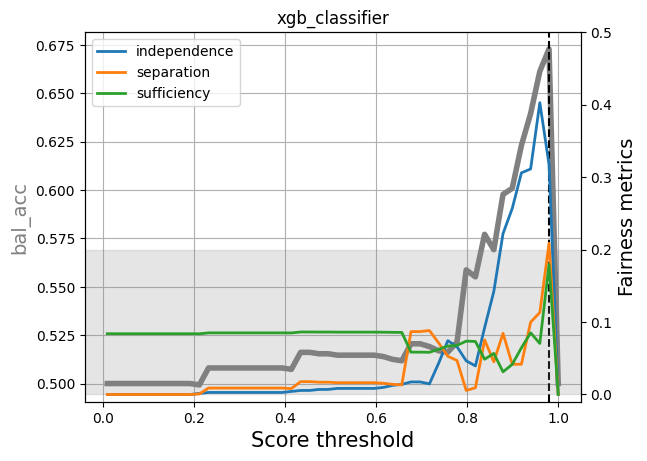

In [10]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


In [11]:
display(Markdown("**Test set results**"))
utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])

**Test set results**

Threshold corresponding to *best balanced accuracy*: 0.9798
AUC: 0.8072
Balanced accuracy: 0.7180
Accuracy: 0.5360
Independence ( |ΔP(Y_pred = 1)| ): 0.4381
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2026
Sufficiency ( |ΔPPV| ) : 0.0116


## Técnicas de preprocesado

### Reponderación

In [12]:
%%time 
# Nombramos al modelo
fairness_method = '_reweighting'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit(data_train_copy)

data_train_copy = PreProcessor.transform(data_train_copy)
data_val_copy = PreProcessor.transform(data_val_copy)
data_test_copy = PreProcessor.transform(data_test_copy)

CPU times: user 4.45 s, sys: 3.86 s, total: 8.31 s
Wall time: 11.1 s


De aquí en adelante, se aplica el modelo de preferencia de manera estándar

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6025
Balanced accuracy: 0.5841
Accuracy: 0.4547
Independence ( |ΔP(Y_pred = 1)| ): 0.4047
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1899
Sufficiency ( |ΔPPV| ) : 0.9553
CPU times: user 25.4 s, sys: 24.6 s, total: 50 s
Wall time: 1min 10s


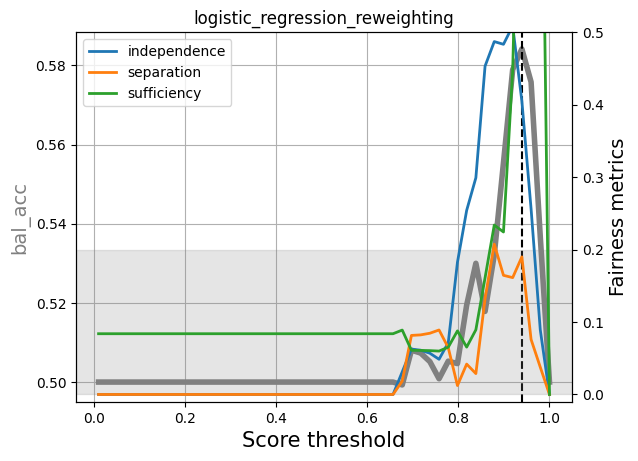

In [13]:
%%time 

# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9798
AUC: 0.7285
Balanced accuracy: 0.6730
Accuracy: 0.5147
Independence ( |ΔP(Y_pred = 1)| ): 0.3173
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2086
Sufficiency ( |ΔPPV| ) : 0.1794
CPU times: user 46min 48s, sys: 29.2 s, total: 47min 17s
Wall time: 2min 59s


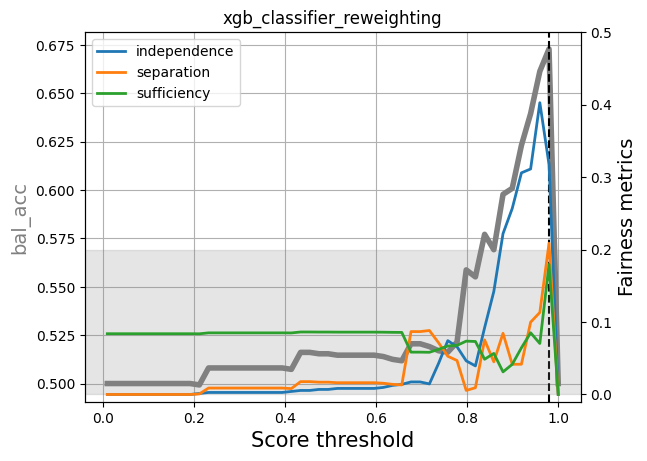

In [14]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


### Eliminador de impacto dispar

In [15]:
%%time 
# Nombramos al modelo
fairness_method = '_di_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
nivel_reparacion = 0.5 # un valor 0 inidica ausencia de reparación (datos se mantienen igual) 
                       # un valor 1 indica reparación completa (se puede perder nivel predictivo).
                       # Se puede establecer cualquier valor entre 0 y 1.

# Hacemos el pre-procesado al conjunto train
# Inicializamos la clase de pre-procesado 
PreProcessor = DisparateImpactRemover(
    repair_level=nivel_reparacion,
    sensitive_attribute=sensitive_attribute
)
# Pre-procesamos (modifica los datos)
PreProcessor.fit_transform(data_train_copy)

data_train_copy = PreProcessor.fit_transform(data_train_copy)
data_val_copy = PreProcessor.fit_transform(data_val_copy)
data_test_copy = PreProcessor.fit_transform(data_test_copy)

CPU times: user 8.58 s, sys: 3.17 s, total: 11.7 s
Wall time: 15.1 s


Aplicamos los métodos de regresión logística y XGBoost

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.5922
Balanced accuracy: 0.5743
Accuracy: 0.4960
Independence ( |ΔP(Y_pred = 1)| ): 0.3284
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2295
Sufficiency ( |ΔPPV| ) : 0.3511
CPU times: user 25.9 s, sys: 28.7 s, total: 54.6 s
Wall time: 56 s


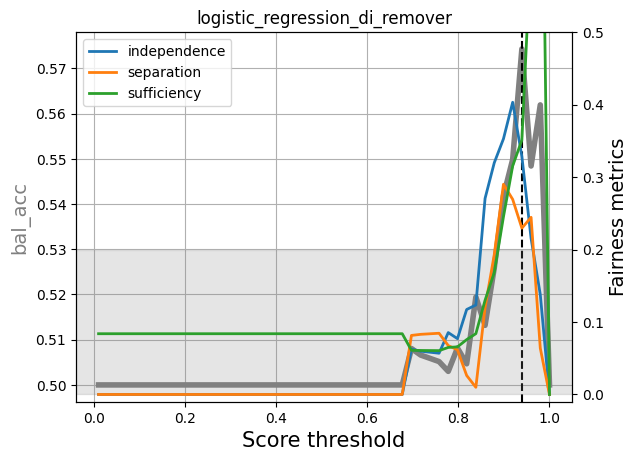

In [16]:
%%time 
# Regresión logística
model_name = 'logistic_regression'

# Parámetros del modelo
fit_params = {'logisticregression__sample_weight': data_train_copy.instance_weights}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = make_pipeline(
            #StandardScaler(),
            LogisticRegression(solver='liblinear', random_state=seed))

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel(), **fit_params)

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9798
AUC: 0.6661
Balanced accuracy: 0.5870
Accuracy: 0.6533
Independence ( |ΔP(Y_pred = 1)| ): 0.3220
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1227
Sufficiency ( |ΔPPV| ) : 0.1274
CPU times: user 46min 15s, sys: 21.6 s, total: 46min 37s
Wall time: 4min


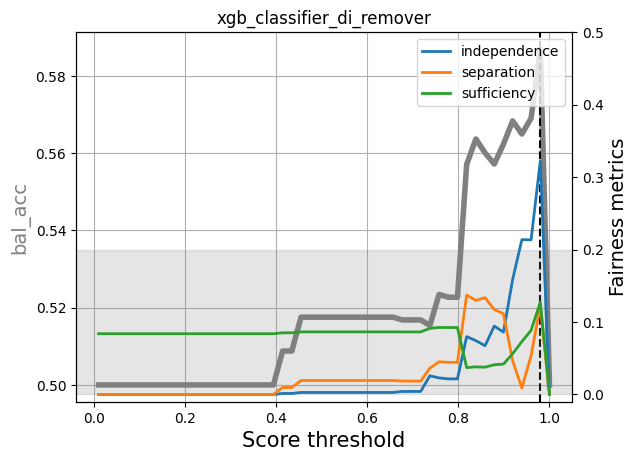

In [17]:
%%time 

# Nombramos al modelo
model_name = 'xgb_classifier'

# Parámetros del modelo
fit_params = {'eval_metric': 'error', 'eta':0.1, 'max_depth':6, 'subsample':0.8}

# Asignamos el modelo al diccionario
models[model_name+fairness_method] = XGBClassifier(**fit_params)

# Entrenamos el modelo
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy.features, data_train_copy.labels.ravel())

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])


# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f


## Técnicas de inprocesado

### Eliminador de prejuicios por regularización

In [18]:
%%time 
# Nombramos al modelo
model_name = 'prejudice_remover'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Parámetros del modelo
η = 50.0 # hyper-parameter de regularización

# Inicializamos el modelo y lo asignamos al diccionario
models[model_name] = PrejudiceRemover(sensitive_attr=sensitive_attribute, eta=η)

# Entrenamos el modelo
models[model_name] = models[model_name].fit(data_train_copy)

FileNotFoundError: [Errno 2] No such file or directory: 'python'

In [19]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

AttributeError: 'PrejudiceRemover' object has no attribute 'model_name'

### Algoritmo de metafairness

In [20]:
%%time 
# Nombramos al modelo
model_name = 'meta_fairness'

# Parámetros del modelo
# hyper-parameter de regularización
τ = 0.8
# métricas fairness a optimizar
quality_constraints = ['sr', 'fdr'] # sr: statistical rate, fdr: false discovery rate

# Optimizamos un modelo nuevo por cada métrica
for quality in quality_constraints:
    
    # Hacemos una copia de los datasets
    data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
    data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)
    
    # nombramos al modelo con su métrica específica
    model_name_quality = '{}_{}'.format(model_name, quality)
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_quality] = MetaFairClassifier(tau=τ, sensitive_attr=sensitive_attribute, type=quality, seed=seed)

    # Entrenamos el modelo
    models[model_name_quality] = models[ model_name_quality ].fit( data_train_copy )

/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
/home/arturo_perez/miniconda3/envs/aif360/lib/python3.9/site-packages/scipy/stats/_m

CPU times: user 7min 3s, sys: 6min 6s, total: 13min 9s
Wall time: 1min 23s


In [21]:
%%time 

for quality in quality_constraints:
    
    name_suffix = '_{}'.format(quality)
    print(f'Results for {model_name+name_suffix}')

    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name+name_suffix] = utils.metrics_threshold_sweep_mult(
        dataset=data_val_copy,
        dataset2=data_val2_copy,
        model=models[model_name+name_suffix],
        thresh_arr=thresh_sweep
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name+name_suffix] = utils.describe_metrics(metrics_sweep[model_name+name_suffix])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name+name_suffix] = utils.compute_metrics_mult(
        dataset=data_test_copy, 
        dataset2=data_test2_copy,
        model=models[model_name+name_suffix], 
        threshold=metrics_best_thresh_validate[model_name+name_suffix]['best_threshold'])

    utils.print_metrics(metrics_best_thresh_validate[model_name+name_suffix])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    # plt.title(model_name+name_suffix)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+name_suffix])
    a.set_title(model_name+name_suffix)
    f

Results for meta_fairness_sr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4388
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838


Results for meta_fairness_fdr
Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.4494
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838


CPU times: user 54 s, sys: 1min 14s, total: 2min 8s
Wall time: 1min 47s


### Eliminación de prejuicios adversarios

In [22]:
%%time

# Nombramos al modelo
model_name = 'NN_adversarial_debiasing'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

sess = tf.Session()

models[model_name] = AdversarialDebiasing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    scope_name = 'debiased_classifier',
    debias=True,
    sess=sess,
    num_epochs=80)

models[model_name].fit(data_train_copy)

2024-06-16 21:17:10.220978: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
2024-06-16 21:17:10.505245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 7161.815430; batch adversarial loss: 0.782665
epoch 1; iter: 0; batch classifier loss: 5431.338867; batch adversarial loss: 0.747416
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13;

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.0100
AUC: 0.5000
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838
CPU times: user 24.1 s, sys: 28.5 s, total: 52.6 s
Wall time: 52.6 s


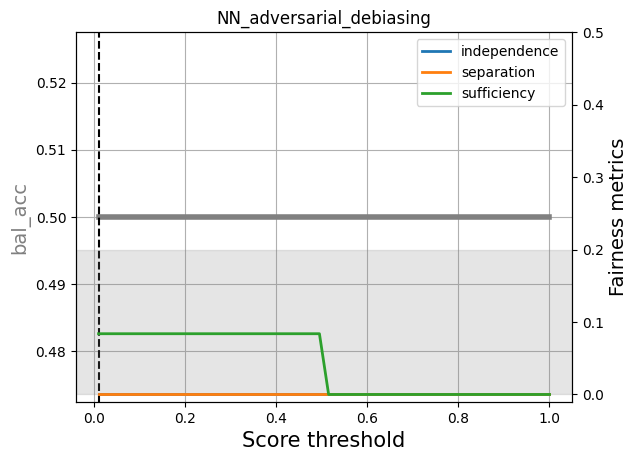

In [23]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

#### Eliminación de prejuicios adversarios: Red neuronal sin eliminación de prejuicios 

In [24]:
%%time

sess.close()
tf.reset_default_graph()
sess = tf.Session()

# Nombramos al modelo
model_name = 'Basic_NN_no_adversarial_debiasing'

# Hacemos una copia de los datasets"
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

models[model_name] = AdversarialDebiasing(privileged_groups = privileged_groups,
                                          unprivileged_groups = unprivileged_groups,
                                          scope_name = 'biased_classifier',
                                          debias=False,
                                          sess=sess,
                                          num_epochs=125)
models[model_name].fit(data_train_copy)

epoch 0; iter: 0; batch classifier loss: 10727.774414
epoch 1; iter: 0; batch classifier loss: 5086.688477
epoch 2; iter: 0; batch classifier loss: 1850.122559
epoch 3; iter: 0; batch classifier loss: 4884.759766
epoch 4; iter: 0; batch classifier loss: 3002.610840
epoch 5; iter: 0; batch classifier loss: 1140.803345
epoch 6; iter: 0; batch classifier loss: 1900.184448
epoch 7; iter: 0; batch classifier loss: 1769.797607
epoch 8; iter: 0; batch classifier loss: 1405.108643
epoch 9; iter: 0; batch classifier loss: 1080.045654
epoch 10; iter: 0; batch classifier loss: 1155.909912
epoch 11; iter: 0; batch classifier loss: 907.202454
epoch 12; iter: 0; batch classifier loss: 379.746429
epoch 13; iter: 0; batch classifier loss: 658.548828
epoch 14; iter: 0; batch classifier loss: 442.441345
epoch 15; iter: 0; batch classifier loss: 247.329559
epoch 16; iter: 0; batch classifier loss: 205.171127
epoch 17; iter: 0; batch classifier loss: 203.107574
epoch 18; iter: 0; batch classifier loss: 16

**Validation set results**

Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.5615
Balanced accuracy: 0.5677
Accuracy: 0.5880
Independence ( |ΔP(Y_pred = 1)| ): 0.2482
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1036
Sufficiency ( |ΔPPV| ) : 0.1253
CPU times: user 23.9 s, sys: 25.8 s, total: 49.7 s
Wall time: 49.8 s


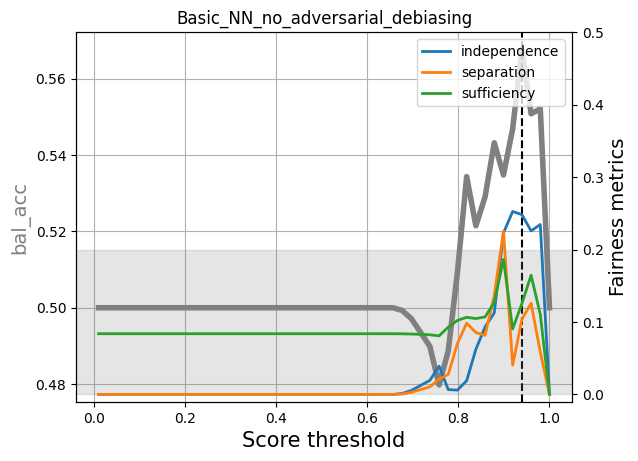

In [25]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name] = utils.metrics_threshold_sweep_mult(
    dataset=data_val_copy,
    dataset2=data_val2_copy,
    model=models[model_name],
    thresh_arr=thresh_sweep
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name] = utils.describe_metrics(metrics_sweep[model_name])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name] = utils.compute_metrics_mult(
    dataset=data_test_copy, 
    dataset2=data_test2_copy,
    model=models[model_name], 
    threshold=metrics_best_thresh_validate[model_name]['best_threshold'])

display(Markdown("**Validation set results**"))
utils.print_metrics(metrics_best_thresh_validate[model_name])

# Graficamos el comportamiento del modelo para el rango de umbrales 
f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name])
a.set_title(model_name)
f

## Técnicas de postprocesado 

### Clasificación de rechazo de opción

In [26]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 38.8 s, sys: 16.9 s, total: 55.7 s
Wall time: 39.4 s


In [27]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2 = data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset2 = data_test2_copy,
        dataset_preds=data_test_preds, 
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for logistic regression**

logistic_regression_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.8217
AUC: 0.6035
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838


logistic_regression_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.8316
AUC: 0.6035
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838


logistic_regression_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.8316
AUC: 0.6035
Balanced accuracy: 0.5000
Accuracy: 0.9240
Independence ( |ΔP(Y_pred = 1)| ): 0.0000
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0000
Sufficiency ( |ΔPPV| ) : 0.0838




In [28]:
%%time 

# Nombramos al modelo
fairness_method = '_reject_option'

# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# métricas fair a optimizar
fair_metrics = {'spd': "Statistical parity difference", 'aod': "Average odds difference", 'eod': "Equal opportunity difference"}

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

data_train2_preds = utils.update_dataset_from_model2(data_train_copy, data_train2_copy, models[model_name])
data_val2_preds = utils.update_dataset_from_model2(data_val_copy, data_val2_copy, models[model_name])
data_test2_preds = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name])

# Optimizamos un modelo nuevo por cada métrica
for key_metric in fair_metrics:
    
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    models[model_name_metric] = RejectOptionClassification(
        unprivileged_groups=unprivileged_groups, 
        privileged_groups=privileged_groups, 
        metric_name=fair_metrics[key_metric],
        metric_lb=-0.01, metric_ub=0.01)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 46.3 s, sys: 7.27 s, total: 53.5 s
Wall time: 42.9 s


In [29]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in fair_metrics:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    metrics_best_thresh_validate[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_val_copy, 
        dataset_preds=data_val_preds, 
        dataset2 = data_val2_copy,
        model=models[model_name_metric], 
        required_threshold=False)
    
    print(model_name_metric)
    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')
    
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy, 
        dataset_preds=data_test_preds, 
        dataset2 = data_test2_copy,
        model=models[model_name_metric], 
        required_threshold=False)

**Validation set results for xgb classifier**

xgb_classifier_reject_option_spd
Threshold corresponding to *best balanced accuracy*: 0.6039
AUC: 0.7285
Balanced accuracy: 0.5154
Accuracy: 0.9227
Independence ( |ΔP(Y_pred = 1)| ): 0.0070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0170
Sufficiency ( |ΔPPV| ) : 0.0861


xgb_classifier_reject_option_aod
Threshold corresponding to *best balanced accuracy*: 0.7722
AUC: 0.7285
Balanced accuracy: 0.5154
Accuracy: 0.9227
Independence ( |ΔP(Y_pred = 1)| ): 0.0070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0170
Sufficiency ( |ΔPPV| ) : 0.0861


xgb_classifier_reject_option_eod
Threshold corresponding to *best balanced accuracy*: 0.7722
AUC: 0.7285
Balanced accuracy: 0.5154
Accuracy: 0.9227
Independence ( |ΔP(Y_pred = 1)| ): 0.0070
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0170
Sufficiency ( |ΔPPV| ) : 0.0861




### Escalado de Platt por grupos

In [30]:
%%time
fairness_method = '_platt_scaling'
model_names = ['logistic_regression', 'xgb_classifier']
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy = True), data_val.copy(deepcopy = True), data_test.copy(deepcopy = True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

for model_name in model_names:
    # Hacemos una copia de las predicciones del modelo de referencia
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_val_preds = utils.update_dataset_from_model(data_val, models[model_name], class_thresh = model_thresh)
    data_val_preds_m = utils.update_dataset_from_model2(data_val, data_val2_copy, models[model_name], class_thresh = model_thresh)
    ## Plat Scaling:
    #1. dividir el validation data usando los groups sensibles
    data_val_preds_priv, data_val_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(
        dataset = data_val_preds, privileged_group_label = list((privileged_groups[0].values()))[0])
    #2. copia el validation data para guardar los scores
    data_val_preds2_m = data_val_preds_m.copy(deepcopy = True)
    data_val_preds2 = data_val_preds.copy(deepcopy = True)
    #3. hacer un modelo para cada grupo
    sensitive_groups_data = {'priv': [data_val_preds_priv, priv_indices],
                             'unpriv': [data_val_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data.items():

        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # Inicializamos el modelo y lo asignamos al diccionario
        models[model_name_group] = LogisticRegression()

        # Realizamos el modelo usando datos para cada grupo en el validation data
        models[ model_name_group ] = models[model_name_group].fit(data_group_list[0].scores,   # data_group_list[0] -> data_val_preds_priv or data_val_preds_unpriv
                                                                  data_val_copy.subset(data_group_list[1]).labels.ravel()) # data_group_list[1] -> priv_indices or unpriv_indices
        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_val_preds2
        # las predicciones de probabilidad son los platt scores
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_val_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        data_val_preds2_m.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
        
        # Evaluamos a los modelos para el rango de umbrales
    thresh_sweep_platt = np.linspace(np.min(data_val_preds2.scores.ravel()),
                                     np.max(data_val_preds2.scores.ravel()),
                                     50)

    metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep_from_scores_mult(
            dataset_true = data_val_copy,
            dataset2 = data_val2_copy,
            dataset_preds = data_val_preds2_m,
            thresh_arr = thresh_sweep_platt
        )

    # Evaluamos las métricas para el mejor umbral y las guardamos
    metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics( metrics_sweep[model_name+fairness_method] )

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    print('\nValidation set results for {}'.format(model_name+fairness_method))
    utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
    # utils.plot_fairness_and_accuracy( metrics_sweep[model_name+fairness_method] )
    # plt.title( model_name+fairness_method )
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
    a.set_title(model_name+fairness_method )
    f



Validation set results for logistic_regression_platt_scaling
Threshold corresponding to *best balanced accuracy*: 0.9291
AUC: 0.6226
Balanced accuracy: 0.6028
Accuracy: 0.4147
Independence ( |ΔP(Y_pred = 1)| ): 0.3816
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1020
Sufficiency ( |ΔPPV| ) : 0.9635

Validation set results for xgb_classifier_platt_scaling
Threshold corresponding to *best balanced accuracy*: 0.9307
AUC: 0.7340
Balanced accuracy: 0.6794
Accuracy: 0.6307
Independence ( |ΔP(Y_pred = 1)| ): 0.5559
Separation ( |ΔFPR + ΔFNR|/2 ): 0.1408
Sufficiency ( |ΔPPV| ) : 0.0338
CPU times: user 54.8 s, sys: 59.2 s, total: 1min 54s
Wall time: 1min 39s


In [31]:
# usa el optimal cutoff para predecir usando el test dato

for model_name in model_names:
    # Obtenemos los scores del modelo de referencia en el teest data
    model_thresh = metrics_best_thresh_validate[model_name]['best_threshold']
    data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name], class_thresh = model_thresh)
    data_test_preds_m = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name], class_thresh = model_thresh)
    
    # 1. dividir el test data usando los groups sensibles
    data_test_preds_priv, data_test_preds_unpriv, priv_indices, unpriv_indices = utils.split_dataset_on_sensitive_attribute(dataset = data_test_preds,
                                                                                                                            privileged_group_label = list((privileged_groups[0].values()))[0])
    # 2. copia el test data para guardar los platt scores
    data_test_preds2 = data_test_preds.copy(deepcopy = True)
    data_test_preds2_m = data_test_preds_m.copy(deepcopy = True)
    
    # 3. predecir con el modelo de cada grupo
    sensitive_groups_data_test = {'priv': [data_test_preds_priv, priv_indices],
                                  'unpriv': [data_test_preds_unpriv, unpriv_indices]}

    for group, data_group_list in sensitive_groups_data_test.items():    
        # nombramos al modelo con su grupo específico
        model_name_group = '{}_{}_{}'.format(model_name, fairness_method, group)

        # haz predicciones de probabilidad con el modelo de cada groupo y guardar lo en data_test_preds2
        scores_group = models[model_name_group].predict_proba(data_group_list[0].scores)
        pos_ind_group = np.where(models[model_name_group].classes_ == data_group_list[0].favorable_label)[0][0]
        data_test_preds2.scores[data_group_list[1]] = scores_group[:, pos_ind_group].reshape(-1,1)
    
    metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_from_scores_mult(dataset_true = data_test_copy,
                                                                                             dataset_pred = data_test_preds2_m,
                                                                                             dataset2 = data_test2_copy,
                                                                                             threshold = metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'])
    print('\nTest set results for {}'.format(model_name+fairness_method))
    utils.print_metrics(metrics_best_thresh_test[model_name+fairness_method])


Test set results for logistic_regression_platt_scaling
Threshold corresponding to *best balanced accuracy*: 0.9291
AUC: 0.6302
Balanced accuracy: 0.5740
Accuracy: 0.5187
Independence ( |ΔP(Y_pred = 1)| ): 0.5124
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0739
Sufficiency ( |ΔPPV| ) : 0.9380

Test set results for xgb_classifier_platt_scaling
Threshold corresponding to *best balanced accuracy*: 0.9307
AUC: 0.8072
Balanced accuracy: 0.7261
Accuracy: 0.7840
Independence ( |ΔP(Y_pred = 1)| ): 0.3463
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0160
Sufficiency ( |ΔPPV| ) : 0.0395


### Procesador de probabilidades igualadas

#### Usando labels

In [32]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


#data_train2_preds = utils.update_dataset_from_model2(data_train_copy, data_train2_copy, models[model_name])
#data_val2_preds = utils.update_dataset_from_model2(data_val_copy, data_val2_copy, models[model_name])
#data_test2_preds = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name])

# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    #cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: No loop matching the specified signature and casting was found for ufunc logical_and

In [33]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset2 = data_test2_copy,
    dataset_preds=data_test_preds,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

AttributeError: 'NoneType' object has no attribute 'x'

In [34]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

#data_train2_preds = utils.update_dataset_from_model2(data_train_copy, data_train2_copy, models[model_name])
#data_val2_preds = utils.update_dataset_from_model2(data_val_copy, data_val2_copy, models[model_name])
#data_test2_preds = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name])


# Inicializamos el modelo (dadas las predicciones, no los scores) y lo asignamos al diccionario
models[model_name+fairness_method] = EqOddsPostprocessing(
    privileged_groups = privileged_groups,
    unprivileged_groups = unprivileged_groups,
    cost_constraint = quality,
    seed = seed)

# Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
models[model_name+fairness_method] = models[model_name+fairness_method].fit(data_train_copy, data_train_preds)

TypeError: __init__() got an unexpected keyword argument 'cost_constraint'

In [35]:
%%time 

# Evaluamos al modelo para un rango de umbrales
metrics_sweep[model_name+fairness_method] = utils.metrics_postprocessing_threshold_sweep(
    dataset_true=data_val_copy,
    dataset_preds=data_val_preds,
    model=models[model_name+fairness_method],
    thresh_arr=thresh_sweep,
    scores_or_labels='labels'
)

# Evaluamos las métricas para el mejor umbral
metrics_best_thresh_validate[model_name+fairness_method] = utils.describe_metrics(metrics_sweep[model_name+fairness_method])

# Usando el mejor umbral, calculamos las métricas en el test set
metrics_best_thresh_test[model_name+fairness_method] = utils.compute_metrics_postprocessing_mult(
    dataset_true=data_test_copy,
    dataset_preds=data_test_preds,
    dataset2=data_test2_copy,
    model=models[model_name+fairness_method], 
    threshold=metrics_best_thresh_validate[model_name+fairness_method]['best_threshold'], 
    scores_or_labels='labels')

utils.print_metrics(metrics_best_thresh_validate[model_name+fairness_method])
print('\n')

# Graficamos el comportamiento del modelo para el rango de umbrales 
# utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
# plt.title(model_name+fairness_method)

f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name+fairness_method])
a.set_title(model_name+fairness_method)
f

KeyError: 'xgb_classifier_equal_odds'

#### Usando scores

In [36]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'logistic_regression'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])

#data_train2_preds = utils.update_dataset_from_model2(data_train_copy, data_train2_copy, models[model_name])
#data_val2_preds = utils.update_dataset_from_model2(data_val_copy, data_val2_copy, models[model_name])
#data_test2_preds = utils.update_dataset_from_model2(data_test_copy, data_test2_copy, models[model_name])

# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 8.28 s, sys: 18.1 s, total: 26.4 s
Wall time: 11.3 s


In [37]:
display(Markdown("**Validation set results for logistic regression**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds, 
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for logistic regression**

Results for logistic_regression_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6035
Balanced accuracy: 0.5863
Accuracy: 0.4587
Independence ( |ΔP(Y_pred = 1)| ): 0.3829
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2160
Sufficiency ( |ΔPPV| ) : 0.9557


Results for logistic_regression_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6035
Balanced accuracy: 0.5863
Accuracy: 0.4587
Independence ( |ΔP(Y_pred = 1)| ): 0.3829
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2160
Sufficiency ( |ΔPPV| ) : 0.9557


Results for logistic_regression_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.9394
AUC: 0.6035
Balanced accuracy: 0.5951
Accuracy: 0.4600
Independence ( |ΔP(Y_pred = 1)| ): 0.4329
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0910
Sufficiency ( |ΔPPV| ) : 0.9557




In [38]:
%%time 
# Nombramos al modelo
fairness_method = '_equal_odds'
# Nombre del modelo al que le aplicaremos post-processing
model_name = 'xgb_classifier'

# Hacemos una copia de los datasets
data_train_copy, data_val_copy, data_test_copy = data_train.copy(deepcopy=True), data_val.copy(deepcopy=True), data_test.copy(deepcopy=True)
data_train2_copy, data_val2_copy, data_test2_copy = data_train2.copy(deepcopy=True), data_val2.copy(deepcopy=True), data_test2.copy(deepcopy=True)

# Hacemos una copia de las predicciones del modelo de referencia
data_train_preds = utils.update_dataset_from_model(data_train_copy, models[model_name])
data_val_preds = utils.update_dataset_from_model(data_val_copy, models[model_name])
data_test_preds = utils.update_dataset_from_model(data_test_copy, models[model_name])


# Parámetros del modelo
# métricas fair a optimizar
quality_constraints = ["weighted", 'fnr', 'fpr'] # "weighted" average of fnr and fpr

for quality in quality_constraints:
    # nombramos al modelo con su métrica específica
    model_name_metric = model_name + fairness_method + '_' + quality
    
    # Inicializamos el modelo y lo asignamos al diccionario
    models[model_name_metric] = CalibratedEqOddsPostprocessing(
        privileged_groups=privileged_groups,
        unprivileged_groups=unprivileged_groups,
        cost_constraint=quality,
        seed=seed)

    # Realizamos el post-procesado en función de las clases realies (data_copy) y las predicciones del modelo de referencia (data_preds)
    models[model_name_metric] = models[model_name_metric].fit(data_train_copy, data_train_preds)

CPU times: user 9.91 s, sys: 5.34 s, total: 15.2 s
Wall time: 11.3 s


In [39]:
display(Markdown("**Validation set results for xgb classifier**"))
for key_metric in quality_constraints:
    
    model_name_metric = model_name + fairness_method + '_' + key_metric
    
    print(f'Results for {model_name_metric}')
    
    # Evaluamos al modelo para un rango de umbrales
    metrics_sweep[model_name_metric] = utils.metrics_postprocessing_threshold_sweep(
        dataset_true=data_val_copy,
        dataset_preds=data_val_preds,
#        dataset2=data_val2_copy,
        model=models[model_name_metric],
        thresh_arr=thresh_sweep,
        scores_or_labels='scores'
    )

    # Evaluamos las métricas para el mejor umbral
    metrics_best_thresh_validate[model_name_metric] = utils.describe_metrics(metrics_sweep[model_name_metric])

    # Usando el mejor umbral, calculamos las métricas en el test set
    metrics_best_thresh_test[model_name_metric] = utils.compute_metrics_postprocessing_mult(
        dataset_true=data_test_copy,
        dataset_preds=data_test_preds,
        dataset2=data_test2_copy,
        model=models[model_name_metric], 
        threshold=metrics_best_thresh_validate[model_name_metric]['best_threshold'], 
        scores_or_labels='scores')

    utils.print_metrics(metrics_best_thresh_validate[model_name_metric])
    print('\n')

    # Graficamos el comportamiento del modelo para el rango de umbrales 
    # utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    # plt.title(model_name_metric)
    
    f,a = utils.plot_fairness_and_accuracy(metrics_sweep[model_name_metric])
    a.set_title(model_name_metric)
    f

**Validation set results for xgb classifier**

Results for xgb_classifier_equal_odds_weighted
Threshold corresponding to *best balanced accuracy*: 0.9192
AUC: 0.7285
Balanced accuracy: 0.5831
Accuracy: 0.8693
Independence ( |ΔP(Y_pred = 1)| ): 0.3164
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0145
Sufficiency ( |ΔPPV| ) : 0.1054


Results for xgb_classifier_equal_odds_fnr
Threshold corresponding to *best balanced accuracy*: 0.9596
AUC: 0.7285
Balanced accuracy: 0.5544
Accuracy: 0.2360
Independence ( |ΔP(Y_pred = 1)| ): 0.1329
Separation ( |ΔFPR + ΔFNR|/2 ): 0.0283
Sufficiency ( |ΔPPV| ) : 0.1421


Results for xgb_classifier_equal_odds_fpr
Threshold corresponding to *best balanced accuracy*: 0.9798
AUC: 0.7285
Balanced accuracy: 0.6722
Accuracy: 0.5133
Independence ( |ΔP(Y_pred = 1)| ): 0.3685
Separation ( |ΔFPR + ΔFNR|/2 ): 0.2751
Sufficiency ( |ΔPPV| ) : 0.4795




## Comparación de modelos

Podemos usar los diccionarios que resumen la calidad de los modelos fair para compararlos todos.

### Resultados en validación

In [40]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_validate).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.939388,0.586314,0.458667,0.408861,0.192111,0.955696,0.603529
xgb_classifier,0.979796,0.672970,0.514667,0.317288,0.208618,0.179412,0.728463
logistic_regression_reweighting,0.939388,0.584150,0.454667,0.404683,0.189859,0.955272,0.602516
xgb_classifier_reweighting,0.979796,0.672970,0.514667,0.317288,0.208618,0.179412,0.728463
logistic_regression_di_remover,0.939388,0.574315,0.496000,0.328430,0.229481,0.351149,0.592213
xgb_classifier_di_remover,0.979796,0.586998,0.653333,0.321988,0.122673,0.127425,0.666110
meta_fairness_sr,0.010000,0.500000,0.924000,0.000000,0.000000,0.083827,0.438824
meta_fairness_fdr,0.010000,0.500000,0.924000,0.000000,0.000000,0.083827,0.449381
NN_adversarial_debiasing,0.010000,0.500000,0.924000,0.000000,0.000000,0.083827,0.500000
Basic_NN_no_adversarial_debiasing,0.939388,0.567745,0.588000,0.248172,0.103615,0.125348,0.561454


### Resultados en test

In [41]:
algorithm_performance_summary = pd.DataFrame(metrics_best_thresh_test).T
algorithm_performance_summary

,best_threshold,bal_acc,acc,independence,separation,sufficiency,auc
logistic_regression,0.939388,0.575642,0.444000,0.418508,0.076342,0.943894,0.630170
xgb_classifier,0.979796,0.718021,0.536000,0.438058,0.202638,0.011594,0.807193
logistic_regression_reweighting,0.939388,0.575642,0.444000,0.418508,0.076342,0.943894,0.630034
xgb_classifier_reweighting,0.979796,0.718021,0.536000,0.438058,0.202638,0.011594,0.807193
logistic_regression_di_remover,0.939388,0.575938,0.509333,0.380472,0.008603,0.061281,0.631036
xgb_classifier_di_remover,0.979796,0.663493,0.721333,0.372078,0.036218,0.050000,0.763188
meta_fairness_sr,0.010000,0.500000,0.914667,0.000000,0.000000,0.031130,0.448205
meta_fairness_fdr,0.010000,0.500000,0.914667,0.000000,0.000000,0.031130,0.451235
NN_adversarial_debiasing,0.010000,0.500000,0.914667,0.000000,0.000000,0.031130,0.500000
Basic_NN_no_adversarial_debiasing,0.939388,0.584457,0.602667,0.334360,0.124121,0.081072,0.621549


In [42]:
algorithm_performance_summary.to_csv('PERFORMANCE_HOMECREDIT_MULTSENS', index = True, sep=',', encoding='utf-8')